In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
! nvidia-smi

Mon Dec 16 03:20:56 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P0              42W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
! pip install datasets==3.1.0
# #load_dataset sometimes hangs on a higher version
! pip install transformers accelerate evaluate

In [4]:
! unzip /content/data.zip

Archive:  /content/data.zip
replace data/all_dev.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace data/all_train.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


# Preprocessing

In [5]:
from datasets import load_dataset
import os
import torch
from torch import nn
import numpy as np
import random
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizerFast, DistilBertForQuestionAnswering, AutoModelForQuestionAnswering, AutoTokenizer
from accelerate import Accelerator
from tqdm import tqdm
from torch.optim import AdamW
from transformers import get_scheduler
from evaluate import EvaluationModule
from evaluate import load as load_metric
from torch.optim import Optimizer

# we set up some seeds so that we can reproduce results
seed = 123
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True


## loading dataset

In [6]:
def load_data(folder_path: str):
    data_files = {"train": os.path.join(folder_path, "all_train.json"), "dev": os.path.join(folder_path, "all_dev.json")}
    dataset = load_dataset('json', data_files=data_files)
    return dataset

In [7]:
# Change train.json / dev.json to the appropriate filepaths =====
# folder_path = "/content/drive/MyDrive/ComputationalLinguistics/Final"
folder_path = "/content/data"
# loading dataset
data_files = {"train": os.path.join(folder_path, "all_train.json"), "dev": os.path.join(folder_path, "all_dev.json")}
# loading dataset
dataset = load_dataset('json', data_files=data_files)

In [8]:
# defining model and tokenizer
def load_model(model_name: str):
    tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)
    bert_model = DistilBertForQuestionAnswering.from_pretrained(model_name).to(device)
    return bert_model, tokenizer

device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "distilbert-base-uncased"
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)
bert_model = DistilBertForQuestionAnswering.from_pretrained(model_name).to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoi

## constructing dataset class

In [9]:
# defining dataset class for dataloaders
class QADataset(Dataset):
    def __init__(self, data: list, tokenizer: AutoTokenizer, max_length: int = 512):
        """
        data: list
            list of json objects
        tokenizer: AutoTokenizer
            tokenizer for the model
        max_length: int
            max length of the input
        """
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # get elements in each sample
        # each sample is in json's format
        example = self.data[idx]
        question = example['questions'][0]['input_text'] # str
        context = example['contexts'] # str
        answer = example['answers'][0] # dict: span_start, span_end, answer string...
        # Tokenize question and context together => [CLS]<question tokens>[SEP]<context tokens>[SEP][PAD]...
        inputs = self.tokenizer(
            question,
            context,
            truncation="only_second",
            max_length=self.max_length,
            # offset mapping helps us map tokens back to a word
            return_offsets_mapping=True,
            padding="max_length",
            # return_token_type_ids=True
        )
        """
        offsets: list
            [(i, j), ... ]
            each n-th item in the list is a tuple, corresponding to the n-th token in an encoded sequence
            i = start position of the token in the original sequence
            j = end position of the token in the original sequence
        """
        offsets = inputs.pop('offset_mapping')
        start_char = answer["span_start"]
        end_char = answer["span_end"]
        sequence_ids = inputs.sequence_ids(0)
        # getting context's position
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1
        # If the answer is not inside the context, or, unanswerable (-1, -1), label it (0, 0)
        if start_char == -1 or end_char == -1 or offsets[context_start][0] > end_char or offsets[context_end][1] < start_char:
            inputs["start_positions"] = 0
            inputs["end_positions"] = 0
            inputs['answer_type'] = 0
        else:
            # source: https://huggingface.co/docs/transformers/tasks/question_answering
            # Otherwise it's the start and end token positions
            idx = context_start
            # go with an index-ascending way: context_start, context_start + 1...
            while idx <= context_end and offsets[idx][0] <= start_char:
                idx += 1
            inputs["start_positions"] = idx - 1
            idx = context_end
            # go with an index-descending way: context_end, context_end - 1...
            while idx >= context_start and offsets[idx][1] >= end_char:
                idx -= 1
            inputs["end_positions"] = idx + 1
            inputs['answer_type'] = 1
        """
        {
            "inpud_ids":<inpud_ids>,
            "attention_mask":<attention_mask>,
            "start_positions":<start_position>,
            "end_positions":<end_position>,
            "answer_type":<answer_type>
        }
        """
        return {k:torch.tensor(v) for k, v in inputs.items()}


## building up dataloaders

In [10]:
# defining datasets and dataloaders
def load_dataloader(dataset: dict, tokenizer: AutoTokenizer, batch_size: int = 32):
    train_dataset = QADataset(dataset['train'], tokenizer)
    validation_dataset = QADataset(dataset['dev'], tokenizer)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size)
    return train_dataloader, validation_dataloader

batch_size = 32
train_dataset = QADataset(dataset['train'], tokenizer)
validation_dataset = QADataset(dataset['dev'], tokenizer)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size)

# Model-related Preparation for Training and Validation

## Creating joint model class

The class of QuestionAnsweringWithTypePrediction will predict three things: start positions, end positions, and answer types. Start positions and end positions are predicted through BERT-based QA models, while answer types are predicted by a linear classifier.

BERT models returns logits for the two positions, each with the shape of (batch size,  input dimension). The classifer takes the last hidden representation of [CLS] as input and returns logits of (batch size, # of answer type).

In [11]:
# Model that predics spans and answer types
class QuestionAnsweringWithTypePrediction(nn.Module):
    def __init__(self, pretrained_model: AutoModelForQuestionAnswering, answer_type: int = 2):
        """
        pretrained_model: AutoModelForQuestionAnswering
            pretrained model for question answering
        answer_type: int
            number of answer types
        """
        super(QuestionAnsweringWithTypePrediction, self).__init__()
        self.bert_qa = pretrained_model.from_pretrained(model_name)
        self.type_classifier = nn.Linear(self.bert_qa.config.hidden_size, answer_type)  # Binary classification head
    def forward(self, input_ids, attention_mask, token_type_ids=None, start_positions=None, end_positions=None):
        """
        input_ids: torch.Tensor
            input ids for the model
        attention_mask: torch.Tensor
            attention mask for the model
        token_type_ids: torch.Tensor
            token type ids for the model
        start_positions: torch.Tensor
            start positions for the model
        end_positions: torch.Tensor
            end positions for the model
        """
        outputs = self.bert_qa(
            input_ids, attention_mask=attention_mask,
            # token_type_ids=token_type_ids,
            start_positions = start_positions, end_positions = end_positions, output_hidden_states=True
        )
        # get the representation of [CLS] from the last hidden state
        pooled_output = outputs.hidden_states[-1][:, 0, :]
        # get the output logits of linear classifier
        type_logits = self.type_classifier(pooled_output)
        # returning logits for loss calculation
        return {
            "start_logits": outputs.start_logits,
            "end_logits": outputs.end_logits,
            "type_logits": type_logits
        }
# loss term according to the paper
class Loss(nn.Module):
    def __init__(self):
        super(Loss, self).__init__()
        self.loss_fn = nn.CrossEntropyLoss()
    def forward(self, start_logits, end_logits, type_logits, start_positions, end_positions, type_labels):
        """
        start_logits: torch.Tensor
            start logits for the model
        end_logits: torch.Tensor
            end logits for the model
        type_logits: torch.Tensor
            type logits for the model
        """
        # # get softmax of the logits
        # # log_softmax is a compound function, more stable than -log(softmax()) numericaly
        # loss_start = -nn.functional.log_softmax(start_logits, dim = -1)[:, start_positions]
        # loss_end = -nn.functional.log_softmax(end_logits, dim = -1)[:, end_positions]
        # loss_type = -nn.functional.log_softmax(type_logits, dim = -1)[:, type_labels]
        # return loss_start.mean() + loss_end.mean() + loss_type.mean()
        # # This one does not works! Not sure why...
        # # nearly all predictions of position are index 0


        # This one works!
        loss_start = self.loss_fn(start_logits, start_positions)
        loss_end = self.loss_fn(end_logits, end_positions)
        loss_type = self.loss_fn(type_logits, type_labels)
        return loss_start + loss_end + loss_type

## evaluation functions

In [12]:
def evaluate(model, dataloader, loss_fn, device):
    """
    Evaluate a question-answering model on precision, recall, and F1 score.

    Parameters:
    -----------
    model : torch.nn.Module
        The model to evaluate: QuestionAnsweringWithTypePrediction
    dataloader : torch.utils.data.DataLoader
        DataLoader for test data.
    loss_fn : nn.Module
        Loss function for evaluation.
    device : torch.device
        The device for computation.

    Returns:
    --------
    dict
        Average loss
    """
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Validation Progress", total=len(dataloader), leave=True, ncols=100):
            # Move batch to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            start_positions = batch['start_positions'].to(device)
            end_positions = batch['end_positions'].to(device)
            answer_type = batch['answer_type'].to(device)
            # Forward pass
            outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
            start_logits = outputs["start_logits"]
            end_logits = outputs["end_logits"]
            type_logits = outputs["type_logits"]
            # Calculate loss
            loss = loss_fn(
                start_logits, end_logits, type_logits,
                start_positions, end_positions, answer_type
            )
            total_loss += loss.item()
    avg_loss = total_loss / len(dataloader)
    return {
        "loss": avg_loss,
    }

def calculate_f1_precision_recall(y_pred, y_true):
    """
    Calculate precision, recall, and F1 score.
    Parameters:
    -----------
    y_pred : str
        Predicted string.
    y_true : str
        True string.
    Returns:
    --------
    tuple
        Precision, recall, and F1 score
    """
    # Calculate overlap
    y_pred = y_pred.split()
    y_true = y_true.split()
    pred_tokens = set(y_pred)
    true_tokens = set(y_true)
    common_tokens = pred_tokens & true_tokens
    # Precision and recall
    precision = len(common_tokens) / len(pred_tokens) if pred_tokens else 0.0
    recall = len(common_tokens) / len(true_tokens) if true_tokens else 0.0
    # F1 score
    if precision + recall > 0:
        f1 = 2 * (precision * recall) / (precision + recall)
    else:
        f1 = 0.0
    return precision, recall, f1

def get_prediction_score(model, tokenizer, dataloader, device):
    """
    Evaluate a question-answering model on precision, recall, and F1 score.

    Parameters:
    -----------
    model : torch.nn.Module
        The model to evaluate.
    dataloader : torch.utils.data.DataLoader
        DataLoader for test data.
    loss_fn : nn.Module
        Loss function for evaluation.
    device : torch.device
        The device for computation.
    Returns:
    --------
    dict
        Average loss
    """
    predictions = {"precision":[], "recall":[], "f1":[]}
    model.eval()
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Validation Progress", total=len(dataloader), leave=True, ncols=100):
            # Move batch to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            start_positions = batch['start_positions'].to(device)
            end_positions = batch['end_positions'].to(device)
            answer_type = batch['answer_type'].to(device)
            context_length = input_ids.size(1)
            # Forward pass
            outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
            start_logits = outputs["start_logits"]
            end_logits = outputs["end_logits"]
            # type_logits = outputs["type_logits"].argmax(dim=-1)
            for i in range(len(start_logits)):
                pred_start = start_logits[i].argmax(dim=-1).item()
                pred_end = end_logits[i].argmax(dim=-1).item()
                # making sure no out-of-bound indices
                pred_start, pred_end = max(0, pred_start), min(pred_end, end_logits.size(-1))
                # making sure start <= end
                pred_start, pred_end = min(pred_start, pred_end), max(pred_start, pred_end)
                # getting ground positions
                true_start, true_end = start_positions[i].item(), end_positions[i].item()
                # converting ids to tokens
                y_pred = tokenizer.convert_ids_to_tokens(input_ids[i][pred_start:(pred_end + 1)])
                y_pred = tokenizer.convert_tokens_to_string(y_pred)
                # converting tokens back to strings
                y_true = tokenizer.convert_ids_to_tokens(input_ids[i][true_start:(true_end + 1)])
                y_true = tokenizer.convert_tokens_to_string(y_true)
                # calculating scores
                precision, recall, f1 = calculate_f1_precision_recall(y_pred, y_true)
                predictions["precision"].append(precision)
                predictions["recall"].append(recall)
                predictions["f1"].append(f1)
    predictions = {key:(sum(value) / dataloader.dataset.__len__()) for key, value in predictions.items()}
    return predictions

# train function

In [13]:
def train(model: torch.nn.Module,
          optimizer: Optimizer,
          num_epochs: int,
          train_dataloader: DataLoader,
          validation_dataloader: DataLoader,
          loss_fn: nn.Module,
          lr_scheduler: torch.optim.lr_scheduler.LambdaLR,
          device: torch.device,
          accum_iter: int,
          accelerator: Accelerator
          ) -> None:
    """
    Trains a model by performing forward passes and backpropagating on batches to optimize loss.

    Parameters:
    -----------
    model : torch.nn.Module
        The model to be trained.
    optimizer : torch.optim.Optimizer
        The training optimizer.
    num_epochs : int
        Number of epochs to train for.
    train_dataloader : DataLoader
        DataLoader containing training examples.
    validation_dataloader : DataLoader
        DataLoader containing validation examples.
    loss_fn : nn.Module
        Loss function for evaluation.
    accum_iter : int
        Number of steps to accumulate gradients before updating weights.
    lr_scheduler : torch.optim.lr_scheduler.LambdaLR
        Learning rate scheduler.
    device : torch.device
        The device that the training will be performed on.
    accelerator: Accelerator
        The accelerator for distributed training.
    """
    print("Training begins...")
    for epoch in range(num_epochs):
        model.train()
        train_metrics = {"loss":0.0}
        for batch_idx, batch in tqdm(enumerate(train_dataloader), desc="Training Progress", total=len(train_dataloader), leave=True, ncols=100):
            # getting elements of the batch
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            start_positions = batch['start_positions'].to(device)
            end_positions = batch['end_positions'].to(device)
            answer_type = batch['answer_type'].to(device)
            # model prediction: start_logits, end_logits, type_logits
            outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
            loss = loss_fn(
                outputs["start_logits"], outputs["end_logits"], outputs["type_logits"],
                start_positions, end_positions, answer_type
            )
            accelerator.backward(loss)
            # gradient accumulation technique, helping reducing memory load
            if ((batch_idx + 1) % accum_iter == 0) or (batch_idx + 1 == len(train_dataloader)):
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()
            train_metrics["loss"] += loss.item()
        # display current result
        print(f"Epoch {epoch+1}\n-------------------------------")
        print("Training")
        for key in train_metrics.keys():
            train_metrics[key] /= len(train_dataloader.dataset)
            print(f"{key}: {train_metrics[key]:>3f}")
        print()
        print("Validation")
        val_metrics = evaluate(model=model, dataloader=validation_dataloader, loss_fn=loss_fn, device=device)
        print()
        for key in val_metrics.keys():
            print()
            print(f"{key}: {val_metrics[key]:>3f}")
        print()


## Model Instantiation and Training

In [14]:
model = QuestionAnsweringWithTypePrediction(bert_model).to(device)

# baseline, no training
score_baseline = get_prediction_score(model, tokenizer, validation_dataloader, device)
print()
print(f"precision: {score_baseline['precision']:>3f}")
print(f"recall: {score_baseline['recall']:>3f}")
print(f"f1: {score_baseline['f1']:>3f}")

Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validation Progress: 100%|██████████████████████████████████████████| 55/55 [00:32<00:00,  1.69it/s]


precision: 0.048043
recall: 0.246843
f1: 0.064559


In [15]:
model_path = os.path.join(folder_path, "model_state_dict.pth")
if os.path.exists(model_path):
    print("loading model from drive")
    model.load_state_dict(torch.load(model_path))
else:
    optimizer = AdamW(model.parameters(), lr=5e-5)
    accum_iter = 4
    num_epochs = 2
    num_training_steps = num_epochs * len(train_dataloader)
    lr_scheduler = get_scheduler(
        "linear",
        optimizer = optimizer,
        num_warmup_steps = 50,
        num_training_steps = num_training_steps
    )
    # reducing precision to fp16 can forge faster computing on T4
    accelerator = Accelerator(mixed_precision="fp16")
    loss_fn = Loss()
    model, optimizer, train_dataloader = accelerator.prepare(model, optimizer, train_dataloader)
    train(model, optimizer, num_epochs, train_dataloader, validation_dataloader, loss_fn, lr_scheduler, device, accum_iter, accelerator)
    torch.save(model.state_dict(), model_path)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Training begins...


Training Progress: 100%|██████████████████████████████████████████| 871/871 [08:18<00:00,  1.75it/s]


Epoch 1
-------------------------------
Training
loss: 0.168507

Validation


Validation Progress: 100%|██████████████████████████████████████████| 55/55 [00:11<00:00,  4.84it/s]




loss: 3.185933



Training Progress: 100%|██████████████████████████████████████████| 871/871 [08:19<00:00,  1.75it/s]


Epoch 2
-------------------------------
Training
loss: 0.081466

Validation


Validation Progress: 100%|██████████████████████████████████████████| 55/55 [00:11<00:00,  4.82it/s]




loss: 2.759846



In [16]:
score_trained = get_prediction_score(model, tokenizer, validation_dataloader, device)
print()
print(f"precision: {score_trained['precision']:>3f}")
print(f"recall: {score_trained['recall']:>3f}")
print(f"f1: {score_trained['f1']:>3f}")

Validation Progress: 100%|██████████████████████████████████████████| 55/55 [00:11<00:00,  4.63it/s]


precision: 0.688941
recall: 0.760322
f1: 0.683175


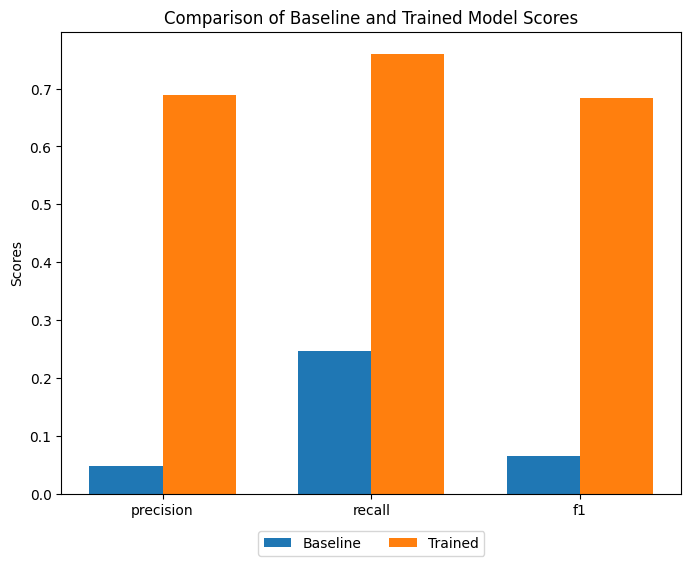

In [17]:
# prompt: generate figure to compare score_trained and score_baseline, let the legend stays at the bottom, either side is fine

import matplotlib.pyplot as plt

def plot_scores(score_baseline: dict, score_trained: dict):
    metrics = ['precision', 'recall', 'f1']
    score_baseline = [score_baseline[metric] for metric in metrics]
    score_trained = [score_trained[metric] for metric in metrics]
    x = range(len(metrics))
    fig, ax = plt.subplots(figsize=(8, 6))
    width = 0.35
    rects1 = ax.bar(x, score_baseline, width, label='Baseline')
    rects2 = ax.bar([i + width for i in x], score_trained, width, label='Trained')
    ax.set_ylabel('Scores')
    ax.set_title('Comparison of Baseline and Trained Model Scores')
    ax.set_xticks([i + width / 2 for i in x])
    ax.set_xticklabels(metrics)
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=2) #legend at the bottom
    plt.show()

plot_scores(score_baseline, score_trained)

# Main

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local

running baseline


Validation Progress: 100%|██████████████████████████████████████████| 55/55 [00:12<00:00,  4.38it/s]
<ipython-input-19-8347008292e9>:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental f


loading model from drive


Validation Progress: 100%|██████████████████████████████████████████| 55/55 [00:10<00:00,  5.00it/s]



baseline
---------------------------------
precision: 0.058903
recall: 0.257688
f1: 0.074815

trained
---------------------------------
precision: 0.688941
recall: 0.760322
f1: 0.683175


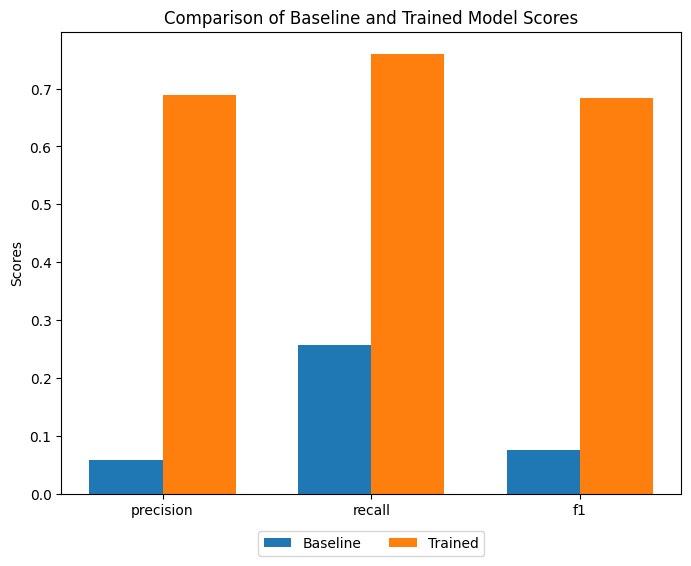

In [19]:
def main():
    """get models and dataloaders"""
    device = "cuda" if torch.cuda.is_available() else "cpu"
    # folder_path = "/content/drive/MyDrive/ComputationalLinguistice/Final"
    folder_path = "/content/data"
    # getting the dataset
    dataset = load_data(folder_path)
    # getting the QA model and tokenizer
    bert_model, tokenizer = load_model("distilbert-base-uncased")
    # getting dataloaders
    train_dataloader, validation_dataloader = load_dataloader(dataset, tokenizer)
    bert_model = bert_model.to(device)
    # getting the target model with the ability to predict start positions, end positions, and answer type
    model = QuestionAnsweringWithTypePrediction(bert_model).to(device)
    """define hypermeter"""
    # Accelerator is our good friend that helps accelerate training progress
    accelerator = Accelerator(mixed_precision="fp16")
    optimizer = AdamW(model.parameters(), lr=5e-5)
    # put model, optimizer, and train_dataloader onto accelerator
    model, optimizer, train_dataloader = accelerator.prepare(model, optimizer, train_dataloader)
    model_path = os.path.join(folder_path, "model_state_dict.pth")
    """model training and inference"""
    # check what our zero-shot model performs
    print("running baseline")
    score_baseline = get_prediction_score(model, tokenizer, validation_dataloader, device)
    print()
    # if model exists, load the weights; train the model otherwise.
    if os.path.exists(model_path):
        print("loading model from drive")
        model.load_state_dict(torch.load(model_path))
    else:
        # self-defined loss according to the paper
        loss_fn = Loss()
        # accumulation step
        accum_iter = 4
        num_epochs = 2
        num_training_steps = num_epochs * len(train_dataloader)
        lr_scheduler = get_scheduler(
            "linear",
            optimizer = optimizer,
            num_warmup_steps = 50,
            num_training_steps = num_training_steps
        )
        # training begins here
        train(model, optimizer, num_epochs, train_dataloader, validation_dataloader, loss_fn, device, accum_iter, accelerator)
        # save the model for inference
        torch.save(model.state_dict(), model_path)
    # check how th model performs after being trained
    score_trained = get_prediction_score(model, tokenizer, validation_dataloader, device)
    print()
    print("baseline")
    print("---------------------------------")
    print(f"precision: {score_baseline['precision']:>3f}")
    print(f"recall: {score_baseline['recall']:>3f}")
    print(f"f1: {score_baseline['f1']:>3f}")
    print()
    print("trained")
    print("---------------------------------")
    print(f"precision: {score_trained['precision']:>3f}")
    print(f"recall: {score_trained['recall']:>3f}")
    print(f"f1: {score_trained['f1']:>3f}")
    # plot the results
    plot_scores(score_baseline, score_trained)

if __name__ == "__main__":
  main()